## Setting

In [1]:
# insert your desired path to work on
import os
from os.path import join
project_path = os.path.dirname(os.getcwd())
# os.chdir(join('..','data'))
os.getcwd()

'C:\\Users\\amanp\\Desktop\\MINOR\\projj\\code'

Run the following section one time per session. This cell links the code folder to the python exectution path.

In [2]:
import sys
sys.path.append(join(project_path, 'code'))

The following cell allows Jupyter Notebooks to detect changes in external code and to automatically update it without restarting the runtime.

In [3]:
%load_ext autoreload
%autoreload 2

Plots settings.

In [4]:
import matplotlib
font = {'family':'Arial', 'size':'15', 'weight':'normal'}

matplotlib.rc('font', **font)

Set folder structure.

In [5]:
config = {
    'main_brazil': 'Brazil',
    'main_peru': 'Peru',
    'baseline': join(project_path, "baseline_models"),
    'output': join(project_path, "code", "saved_models"),
    'metrics': join(project_path, "code", "metrics")
}
project_path

# List comprehension for the folder structure code
[os.makedirs(val, exist_ok=True) for key, val in config.items()]

[None, None, None, None, None]

# **AI4Dengue forecasting**
![](https://drive.google.com/uc?export=view&id=1J5Bt5Cks-e2IV-dEJLHJkuwXFJNFAZgr)

In [6]:
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from glob import glob
from config import DEP_NAMES, GROUPED_VARS, DATA_REDUCER_SETTINGS, DATA_PROCESSING_SETTINGS


In [7]:
dir(utils)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clean',
 'cx',
 'geopandas',
 'pd',
 'plist',
 'plotShape']

# Data

## Load the dataframe
**This dataframe comprises all the variables (climatic, epidemiological etc.) acquired for each Department during a defined number of years.**

In [8]:
dataframe = pd.read_csv(join('dataset', "Brazil_UF_dengue_monthly.csv"))
dataframe.head()
dataframe.iloc[1000]

Date                2004-02-01
Year                      2004
Month                        2
CD_UF                       12
area_km2            164173.431
                       ...    
rdpc_def_vulner         119.68
t_analf_18m              17.79
t_formal_18m             46.45
t_fundc_ocup18m           55.2
t_medioc_ocup18m         39.61
Name: 1000, Length: 62, dtype: object

**Load CNN results as columns to dataframe.**

In [9]:
cnn = pd.read_csv(join('saved_models', "cnn_dataframe.csv")).drop('Unnamed: 0', axis=1)
cnn['CD_UF'] = cnn['CD_UF'].astype(np.int64)

assert dataframe.shape[0] == cnn.shape[0]
assert all(dataframe['CD_UF'].unique() == cnn['CD_UF'].unique())
cnn

,CD_UF,CNN_all,CNN_0-19
0,11,1.000000,1.000000
1,11,1.000000,1.000000
2,11,1.000000,1.000000
3,11,1.000000,1.000000
4,11,32.159859,17.186546
...,...,...,...
6151,53,29.022461,16.795465
6152,53,20.277210,5.658783
6153,53,7.219064,16.862005
6154,53,17.866333,28.619926


In [10]:
dataframe.sort_values(['CD_UF', 'Date'], inplace=True, ignore_index=True)
dataframe

,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,pea10a14,pea15a17,pea18m,t_eletrica,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,18698,34904,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,2019-08-01,2019,8,53,5760.784,0.362744,282.150351,42.202163,304.210083,287.271135,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6152,2019-09-01,2019,9,53,5760.784,0.317748,281.820936,34.023500,307.566780,290.719267,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6153,2019-10-01,2019,10,53,5760.784,0.271795,286.196146,45.486547,307.716003,291.720099,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00
6154,2019-11-01,2019,11,53,5760.784,0.235493,290.445969,64.916154,306.706715,291.496597,...,10706,36652,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00


In [11]:
dataframe = pd.concat([dataframe, cnn[['CNN_all', 'CNN_0-19']]], axis=1)
dataframe

,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,pea18m,t_eletrica,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m,CNN_all,CNN_0-19
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,723839,97.26,27.15,144.93,9.42,51.72,53.83,36.93,32.159859,17.186546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6151,2019-08-01,2019,8,53,5760.784,0.362744,282.150351,42.202163,304.210083,287.271135,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,29.022461,16.795465
6152,2019-09-01,2019,9,53,5760.784,0.317748,281.820936,34.023500,307.566780,290.719267,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,20.277210,5.658783
6153,2019-10-01,2019,10,53,5760.784,0.271795,286.196146,45.486547,307.716003,291.720099,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,7.219064,16.862005
6154,2019-11-01,2019,11,53,5760.784,0.235493,290.445969,64.916154,306.706715,291.496597,...,1361053,99.91,23.48,171.62,3.66,71.62,76.39,61.00,17.866333,28.619926


**'Clean' the dataset (e.g. remove NaN values)**

In [12]:
dataframe = utils.clean(dataframe)
dataframe.head()

Cleaning dataframe...


,Date,Year,Month,CD_UF,area_km2,NDVI_d,dewpoint_temperature_2m_d,humidity_d,max_temperature_2m_d,min_temperature_2m_d,...,t_densidadem2,rdpc_def_vulner,t_analf_18m,t_formal_18m,t_fundc_ocup18m,t_medioc_ocup18m,CNN_all,CNN_0-19,rate_total,rate_019
0,2001-01-01,2001,1,11,237765.347,0.154301,295.674980,88.460308,303.987216,294.155015,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,42.754490,29.124122
1,2001-02-01,2001,2,11,237765.347,0.216873,295.944060,88.856948,304.738755,294.332566,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,17.601025,11.718582
2,2001-03-01,2001,3,11,237765.347,0.239112,296.092747,89.305463,304.620829,294.304126,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,11.072645,6.376287
3,2001-04-01,2001,4,11,237765.347,0.334660,296.186143,88.590375,304.168669,293.921815,...,27.15,144.93,9.42,51.72,53.83,36.93,1.000000,1.000000,5.120298,3.791306
4,2001-05-01,2001,5,11,237765.347,0.378931,295.562972,86.939606,303.903043,293.395959,...,27.15,144.93,9.42,51.72,53.83,36.93,32.159859,17.186546,6.976406,4.652966


In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       6156 non-null   object 
 1   Year                       6156 non-null   int64  
 2   Month                      6156 non-null   int64  
 3   CD_UF                      6156 non-null   int64  
 4   area_km2                   6156 non-null   float64
 5   NDVI_d                     6156 non-null   float64
 6   dewpoint_temperature_2m_d  6156 non-null   float64
 7   humidity_d                 6156 non-null   float64
 8   max_temperature_2m_d       6156 non-null   float64
 9   min_temperature_2m_d       6156 non-null   float64
 10  surface_pressure_d         6156 non-null   float64
 11  temperature_2m_d           6156 non-null   float64
 12  total_precipitation_d      6156 non-null   float64
 13  u_component_of_wind_10m_d  6156 non-null   float

In [14]:
dataframe.to_csv('out.csv',index=False)

## Apply Data Reduction
**Data reduction is applied to three macro groups in order to reduce the number of variables on which the AI framework will be trained. The variables belonging to each group are set with the *PCAgroups* dictionary. The groups are:**
1. ***CLIMATIC VARIABLES***,
2. ***GEO VARIABLES***,
3. ***SOCIO VARIABLES***

In [15]:
print('\033[1m PCA Excluded Variables \033[0m')
utils.plist(GROUPED_VARS['EXCLUDED'])

print('\033[1m Climatic variables \033[0m')
utils.plist(GROUPED_VARS['CLIMATIC VARIABLES'])

print('\033[1m Geo variables \033[0m')
utils.plist(GROUPED_VARS['GEO VARIABLES'])

print('\033[1m Socio variables \033[0m')
utils.plist(GROUPED_VARS['SOCIO VARIABLES'])

print('\033[1m Additional variables \033[0m')
utils.plist(GROUPED_VARS['AUXILIAR'])

print('\033[1m Dengue variables \033[0m')
utils.plist(GROUPED_VARS['DENGUE'])

 PCA Excluded Variables 
----- 1 t_fundc_ocup18m
----- 2 t_medioc_ocup18m
----- 3 PopTotal_Urban_UF
----- 4 PopTotal_Rural_UF
----- 5 total_precipitation_d
----- 6 surface_pressure_d
----- 7 area_km2
----- 8 humidity_d
----- 9 temperature_2m_d
----- 10 min_temperature_2m_d
----- 11 CNN_all
----- 12 CNN_0-19
 Climatic variables 
----- 1 dewpoint_temperature_2m_d
----- 2 max_temperature_2m_d
----- 3 u_component_of_wind_10m_d
----- 4 v_component_of_wind_10m_d
 Geo variables 
----- 1 NDVI_d
----- 2 max_elevation_d
----- 3 mean_elevation_d
----- 4 min_elevation_d
----- 5 stdDev_elevation_d
----- 6 variance_elevation_d
----- 7 Forest_Cover_Percent
----- 8 Urban_Cover_Percent
 Socio variables 
----- 1 Urban_Cover_Percent
----- 2 ivs
----- 3 ivs_infraestrutura_urbana
----- 4 ivs_capital_humano
----- 5 ivs_renda_e_trabalho
----- 6 t_sem_agua_esgoto
----- 7 t_sem_lixo
----- 8 t_vulner_mais1h
----- 9 t_analf_15m
----- 10 t_cdom_fundin
----- 11 t_p15a24_nada
----- 12 t_vulner
----- 13 t_desocup18m

**We selected two types of data reduction methods: PCA (Principal Component Analysis) and PLS (Principal Least Square). The second one is the default solution because it reduces the input data by considering also a second variable that in our case is the Dengue Incidence Rates.**

In [16]:
from data_reduction import pca_reducer, pls_reducer

**Extract climatic, geophysical and socio-economic variables from the dataframe**

In [17]:
X_climatic = dataframe[GROUPED_VARS['CLIMATIC VARIABLES']].values
X_geo = dataframe[GROUPED_VARS['GEO VARIABLES']].values
X_socio = dataframe[GROUPED_VARS['SOCIO VARIABLES']].values


**Extract Dengue variables from the dataframe, apply a root scaling and normalization**

In [18]:
y_dengue = dataframe[GROUPED_VARS['DENGUE']].values
scaler = MinMaxScaler()
y_dengue = scaler.fit_transform(y_dengue)

**Apply data reduction technique**

In [19]:
if DATA_REDUCER_SETTINGS['TYPE'] == 'PLS':
    climatic_vars_reduced = pls_reducer(
        X_climatic,
        y_dengue,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES'])

    geo_vars_reduced = pls_reducer(
        X_geo,
        y_dengue,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES'])

    socio_vars_reduced = pls_reducer(
        X_socio,
        y_dengue,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES'])
    print(socio_vars_reduced.shape    )
elif DATA_REDUCER_SETTINGS['TYPE'] == 'PCA':
    climatic_vars_reduced = pca_reducer(
        X_climatic,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['CLIMATIC VARIABLES'])

    geo_vars_reduced = pca_reducer(
        X_geo,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['GEO VARIABLES'])

    socio_vars_reduced = pca_reducer(
        X_socio,
        DATA_REDUCER_SETTINGS['NUMBER OF COMPONENTS']['SOCIO VARIABLES'])
else:
    print('No data reduction.')

(6156, 10)


## Order reduced data in a new dataframe


**Normalize remaining variables**

In [20]:
x_excluded = dataframe[GROUPED_VARS['EXCLUDED']].values
x_excluded = MinMaxScaler().fit_transform(x_excluded)

In [21]:
X_auxiliar = dataframe[GROUPED_VARS['AUXILIAR']].values
X_auxiliar = MinMaxScaler().fit_transform(X_auxiliar)

**Create a new database with the reduced, the auxiliar and Dengue variables**

In [22]:
independent = {'Year':dataframe.Year.values, 'dep_id':dataframe.CD_UF.values, 't_fundc_ocup18m':x_excluded[:, 0], 't_medioc_ocup18m':x_excluded[:, 1],
               'PopTotal_Urban_UF':x_excluded[:, 2], 'PopTotal_Rural_UF':x_excluded[:, 3], 'total_precipitation_d':x_excluded[:, 4],
               'surface_pressure_d':x_excluded[:, 5], 'area_km2':x_excluded[:, 6], 'humidity_d':x_excluded[:, 7], 'temperature_2m_d':x_excluded[:, 8],
               'min_temperature_2m_d':x_excluded[:, 9], 'CNN_all':x_excluded[:, 10], 'CNN_0-19':x_excluded[:, 11]}

auxiliar    = {'Month': X_auxiliar[:, 0],
               'cases20_99': X_auxiliar[:, 1], 'cases0_19': X_auxiliar[:, 2],
               'RandEffects1':  MinMaxScaler().fit_transform(np.reshape(dataframe.CD_UF.values*dataframe.Month.values, (dataframe.CD_UF.values.shape[0], 1)))[:,0],
               'RandEffects2':  MinMaxScaler().fit_transform(np.reshape(dataframe.CD_UF.values*dataframe.Year.values, (dataframe.CD_UF.values.shape[0], 1)))[:,0],
               'RandEffects3':  MinMaxScaler().fit_transform(np.reshape(dataframe.CD_UF.values*dataframe.Month.values*dataframe.Year.values, (dataframe.CD_UF.values.shape[0], 1)))[:,0]}

climatic    = {'PCA0-Climatic':climatic_vars_reduced[:,0], 'PCA1-Climatic':climatic_vars_reduced[:,1], 'PCA2-Climatic':climatic_vars_reduced[:,2],
               'PCA3-Climatic':climatic_vars_reduced[:,3]}

geo         = {'PCA0-Geo':geo_vars_reduced[:,0], 'PCA1-Geo':geo_vars_reduced[:,1], 'PCA2-Geo':geo_vars_reduced[:,2],
               'PCA3-Geo':geo_vars_reduced[:,3], 'PCA4-Geo':geo_vars_reduced[:,4], 'PCA5-Geo':geo_vars_reduced[:,5]}

socio       = {'PCA0-Socio':socio_vars_reduced[:,0], 'PCA1-Socio':socio_vars_reduced[:,1], 'PCA2-Socio':socio_vars_reduced[:,2],
               'PCA3-Socio':socio_vars_reduced[:,3], 'PCA4-Socio':socio_vars_reduced[:,4], 'PCA5-Socio':socio_vars_reduced[:,5]}

dengue      = {'DengRate_all': y_dengue[:,0], 'DengRate_019': y_dengue[:,1]}

columns     = {**independent, **auxiliar, **climatic, **geo, **socio, **dengue}

reduced_dataframe = pd.DataFrame(columns)
reduced_dataframe.head()
reduced_dataframe.columns

# reduced_dataframe

Index(['Year', 'dep_id', 't_fundc_ocup18m', 't_medioc_ocup18m',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'total_precipitation_d',
       'surface_pressure_d', 'area_km2', 'humidity_d', 'temperature_2m_d',
       'min_temperature_2m_d', 'CNN_all', 'CNN_0-19', 'Month', 'cases20_99',
       'cases0_19', 'RandEffects1', 'RandEffects2', 'RandEffects3',
       'PCA0-Climatic', 'PCA1-Climatic', 'PCA2-Climatic', 'PCA3-Climatic',
       'PCA0-Geo', 'PCA1-Geo', 'PCA2-Geo', 'PCA3-Geo', 'PCA4-Geo', 'PCA5-Geo',
       'PCA0-Socio', 'PCA1-Socio', 'PCA2-Socio', 'PCA3-Socio', 'PCA4-Socio',
       'PCA5-Socio', 'DengRate_all', 'DengRate_019'],
      dtype='object')

In [23]:
reduced_dataframe=reduced_dataframe[reduced_dataframe['Year']>=2004]
reduced_dataframe.to_csv('reduced_2004_2019.csv', index=False)
reduced_dataframe.shape

(5184, 38)

## Create training and validation data
**First of all, the dataframe is divided in two sub-dataframes (training and validation) by using the variable *Year***

In [24]:
new_df=pd.read_csv('dengue_data_with_month.csv')
# Method 3: If you want to create a new DataFrame
reduced_dataframe = new_df.drop('time_idx', axis=1)
print(reduced_dataframe.shape)
print(reduced_dataframe.columns)

(5184, 41)
Index(['Year', 'dep_id', 't_fundc_ocup18m', 't_medioc_ocup18m',
       'PopTotal_Urban_UF', 'PopTotal_Rural_UF', 'total_precipitation_d',
       'surface_pressure_d', 'area_km2', 'humidity_d', 'temperature_2m_d',
       'min_temperature_2m_d', 'CNN_all', 'CNN_0-19', 'Month', 'cases20_99',
       'cases0_19', 'RandEffects1', 'RandEffects2', 'RandEffects3',
       'PCA0-Climatic', 'PCA1-Climatic', 'PCA2-Climatic', 'PCA3-Climatic',
       'PCA0-Geo', 'PCA1-Geo', 'PCA2-Geo', 'PCA3-Geo', 'PCA4-Geo', 'PCA5-Geo',
       'PCA0-Socio', 'PCA1-Socio', 'PCA2-Socio', 'PCA3-Socio', 'PCA4-Socio',
       'PCA5-Socio', 'mosquito_interest', 'sintomas_dengue_interest',
       'dengue_interest', 'DengRate_all', 'DengRate_019'],
      dtype='object')


In [25]:
training_dataframe = reduced_dataframe[reduced_dataframe.Year < 2017]   # Train on years < 2017
validation_dataframe = reduced_dataframe[reduced_dataframe.Year >= 2017]  # Validate on years >= 2017
# Print details
print(f"Training Data: {len(training_dataframe)} rows")
print(f"Validation Data: {len(validation_dataframe)} rows")
training_dataframe.head()
validation_dataframe.head()

Training Data: 4212 rows
Validation Data: 972 rows


,Year,dep_id,t_fundc_ocup18m,t_medioc_ocup18m,PopTotal_Urban_UF,PopTotal_Rural_UF,total_precipitation_d,surface_pressure_d,area_km2,humidity_d,...,PCA1-Socio,PCA2-Socio,PCA3-Socio,PCA4-Socio,PCA5-Socio,mosquito_interest,sintomas_dengue_interest,dengue_interest,DengRate_all,DengRate_019
156,2017,11,0.206751,0.12853,0.020497,0.089637,0.470017,0.816201,0.149352,0.933080,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.11,0.24,0.14,0.032628,0.031062
157,2017,11,0.206751,0.12853,0.020497,0.089637,0.455807,0.813839,0.149352,0.957511,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.14,0.35,0.14,0.028203,0.036438
158,2017,11,0.206751,0.12853,0.020497,0.089637,0.409449,0.815870,0.149352,0.945000,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.26,0.22,0.19,0.020461,0.020310
159,2017,11,0.206751,0.12853,0.020497,0.089637,0.239287,0.822995,0.149352,0.947705,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.15,0.15,0.18,0.008185,0.007766
160,2017,11,0.206751,0.12853,0.020497,0.089637,0.123361,0.827288,0.149352,0.935646,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.12,0.10,0.10,0.005032,0.006372


In [26]:
# Print unique years in each dataset to verify
print("Training Years:", training_dataframe["Year"].unique())
print("Validation Years:", validation_dataframe["Year"].unique())

Training Years: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]
Validation Years: [2017 2018 2019]


In [27]:
from sklearn.preprocessing import StandardScaler
# Create explicit copies to avoid SettingWithCopyWarning
training_dataframe = reduced_dataframe[reduced_dataframe.Year < 2017].copy()
validation_dataframe = reduced_dataframe[reduced_dataframe.Year >= 2017].copy()

# Verify again
train_indices = training_dataframe["Year"]
val_indices = validation_dataframe["Year"]

print("Train years:", training_dataframe["Year"].unique())
print("Validation years:", validation_dataframe["Year"].unique())


# Verify again
print("Train start:", min(train_indices), "Train end:", max(train_indices))
print("Validation start:", min(val_indices), "Validation end:", max(val_indices))
assert min(val_indices) > max(train_indices), "🚨 Data leakage detected! Adjust your validation split."
scaler = StandardScaler()
training_dataframe["DengRate_all"] = scaler.fit_transform(np.log1p(training_dataframe["DengRate_all"]).values.reshape(-1,1))
validation_dataframe["DengRate_all"] = scaler.transform(np.log1p(validation_dataframe["DengRate_all"]).values.reshape(-1,1))


Train years: [2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]
Validation years: [2017 2018 2019]
Train start: 2004 Train end: 2016
Validation start: 2017 Validation end: 2019


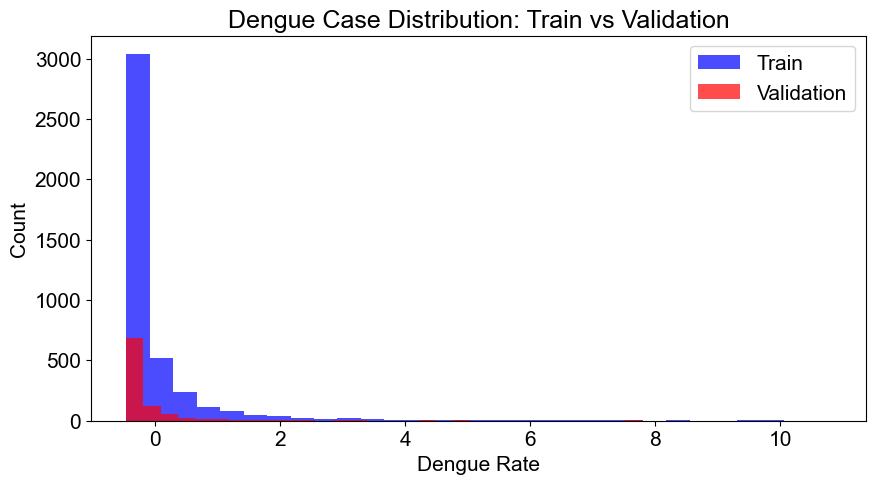

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(training_dataframe["DengRate_all"], bins=30, alpha=0.7, label="Train", color='blue')
plt.hist(validation_dataframe["DengRate_all"], bins=30, alpha=0.7, label="Validation", color='red')
plt.legend()
plt.xlabel("Dengue Rate")
plt.ylabel("Count")
plt.title("Dengue Case Distribution: Train vs Validation")
plt.show()

In [29]:
print(len(training_dataframe),
len(validation_dataframe))
training_dataframe.head()
validation_dataframe.head()

4212 972


,Year,dep_id,t_fundc_ocup18m,t_medioc_ocup18m,PopTotal_Urban_UF,PopTotal_Rural_UF,total_precipitation_d,surface_pressure_d,area_km2,humidity_d,...,PCA1-Socio,PCA2-Socio,PCA3-Socio,PCA4-Socio,PCA5-Socio,mosquito_interest,sintomas_dengue_interest,dengue_interest,DengRate_all,DengRate_019
156,2017,11,0.206751,0.12853,0.020497,0.089637,0.470017,0.816201,0.149352,0.933080,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.11,0.24,0.14,0.057383,0.031062
157,2017,11,0.206751,0.12853,0.020497,0.089637,0.455807,0.813839,0.149352,0.957511,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.14,0.35,0.14,-0.012465,0.036438
158,2017,11,0.206751,0.12853,0.020497,0.089637,0.409449,0.815870,0.149352,0.945000,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.26,0.22,0.19,-0.135424,0.020310
159,2017,11,0.206751,0.12853,0.020497,0.089637,0.239287,0.822995,0.149352,0.947705,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.15,0.15,0.18,-0.332327,0.007766
160,2017,11,0.206751,0.12853,0.020497,0.089637,0.123361,0.827288,0.149352,0.935646,...,0.096634,0.179967,0.325246,0.604686,0.076292,0.12,0.10,0.10,-0.383270,0.006372


**Then the dataset handler is initialized. This object will handle all the operations needed to create, reshape and augment the training and validation dataset to fit the requirements of each Deep Learning or Machine Learning model.**

In [84]:
from datasetHandler import datasetHandler  # <-- Correct import
dataset_handler = datasetHandler(training_dataframe, validation_dataframe)

**Get training and validation vectors from dataframes.**

**Ensure Data Scaling Consistency**

In [85]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
# x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)


In [86]:
print("Common indices:", set(train_indices).intersection(set(val_indices)))


Common indices: set()


In [87]:
# x_train, y_train, x_val, y_val = dataset_handler.get_data(DATA_PROCESSING_SETTINGS['T LEARNING'], DATA_PROCESSING_SETTINGS['T PREDICTION'])

x_train, y_train, x_val, y_val, train_indices, val_indices = dataset_handler.get_data(
    DATA_PROCESSING_SETTINGS['T LEARNING'], DATA_PROCESSING_SETTINGS['T PREDICTION']
)

print('\n\nX Training shape', x_train.shape)
print('Y Training shape', y_train.shape)
print('X Validation shape', x_val.shape)
print('Y Validation shape', y_val.shape)
    

Training data shape: (3564, 24, 47)
Validation data shape: (324, 24, 47)


X Training shape (3564, 24, 47)
Y Training shape (3564, 2)
X Validation shape (324, 24, 47)
Y Validation shape (324, 2)


In [88]:
# # ✅ Check for NaN values
# print("NaN in x_train:", np.isnan(x_train).sum())
# print("NaN in x_val:", np.isnan(x_val).sum())

# # Fix NaN values by replacing them with 0 (or mean imputation if necessary)
# x_train = np.nan_to_num(x_train)
# x_val = np.nan_to_num(x_val)

# # ✅ Ensure Validation Indices Start After Training
# assert min(val_indices) > max(train_indices), "🚨 Data leakage detected! Adjust your validation split."

# # ✅ Check Target Columns
# print("Target columns:", dataset_handler.training.columns[-2:])  # Should be 'DengRate_all' and 'DengRate_019'

# # ✅ If incorrect, check available columns
# print("Available columns:", dataset_handler.training.columns)


In [89]:
# Check which features contain NaN values
nan_features_train = np.isnan(x_train).sum(axis=0)
nan_features_val = np.isnan(x_val).sum(axis=0)

print("Features with NaN in Training:", nan_features_train)
print("Features with NaN in Validation:", nan_features_val)


Features with NaN in Training: [[ 0  0  0 ...  0 27 27]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Features with NaN in Validation: [[ 0  0  0 ...  0 27 27]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [90]:
# nan_threshold = 10  # Drop features with more than 10 NaN values
# columns_to_drop = [i for i, count in enumerate(nan_features_train) if count > nan_threshold]

# x_train = np.delete(x_train, columns_to_drop, axis=1)
# x_val = np.delete(x_val, columns_to_drop, axis=1)

# print(f"Dropped {len(columns_to_drop)} features due to excessive NaNs.")


In [91]:
print("NaN in x_train:", np.isnan(x_train).sum())
print("NaN in x_val:", np.isnan(x_val).sum())


NaN in x_train: 54
NaN in x_val: 54


**Apply data augmention**

In [92]:
x_train_a, y_train_a = dataset_handler.augment(x_train, y_train, DATA_PROCESSING_SETTINGS['AUGMENTATION'])

print('X Training shape', x_train_a.shape)
print('Y Training shape', y_train_a.shape)
print('X Validation shape', x_val.shape)  # Keep x_val as it is
print('Y Validation shape', y_val.shape)


ValueError: `y` must contain only finite values.

In [50]:
# print(f"Before Augmentation: x_train shape = {x_train.shape}, y_train shape = {y_train.shape}")


In [51]:
# print([seq.shape for seq in x_train[:5]])  # Print first few sequence shapes


In [52]:
# print(f"X_train shape: {x_train.shape}")  # Should be (3888, 12, 44)
# print(f"Example sequence shape after warping: {dataset_handler._time_warp(x_train[0]).shape}")  # Should be (12, 44)


**Apply data augmention**

In [53]:
# x_train_a, y_train_a, x_val_a, y_val_a = dataset_handler.augment(x_train, y_train, x_val, y_val, DATA_PROCESSING_SETTINGS['AUGMENTATION'])
# print('X Training shape', x_train_a.shape)
# print('Y Training shape', y_train_a.shape)
# print('X Validation shape', x_val_a.shape)
# print('Y Validation shape', y_val_a.shape)

## TCN

In [59]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, BatchNormalization, Dropout, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import root_mean_squared_error
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime
from glob import glob
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score

In [81]:
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

LSTM_SETTINGS = {
    'EPOCHS': 200,
    'LEARNING RATE': 0.0001,
    'BATCH SIZE': 32,
    'OPTIMZER': 'adam', #'adam',
    'LOSS':'mae',
    'EVALUATION METRIC':['mse'],
    'EARLY STOPPING': 12
}

def build_tcn_model_v2(input_shape, output_units):
    def residual_block(x, filters, dilation_rate):
        shortcut = x
        dropout_rate = min(0.1 + dilation_rate * 0.05, 0.4)  # Increase dropout progressively

        x = layers.Conv1D(filters, kernel_size=3, padding='causal', activation='relu', dilation_rate=dilation_rate,
                          kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.Conv1D(filters, kernel_size=3, padding='causal', activation='relu', dilation_rate=dilation_rate,
                          kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x


    inputs = Input(shape=input_shape)  # Remove the last dimension
    x = layers.Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    # Add residual blocks with increasing dilation rates
    for dilation_rate in [1, 2, 4, 8, 16, 32]:
        x = residual_block(x, filters=64, dilation_rate=dilation_rate)
    
    x = layers.Flatten()(x)
    outputs = layers.Dense(units=output_units, activation='linear')(x)  # For regression
    
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='log_cosh', metrics=['mae'])
    return model

class ImprovedTCNNet:
    def __init__(self, shape, output_units=2):
        self.shape = shape
        self.epochs = LSTM_SETTINGS['EPOCHS']  # Max epochs
        self.batch_size = LSTM_SETTINGS['BATCH SIZE']
        self.lr = LSTM_SETTINGS['LEARNING RATE']
        self.early_stopping_rounds = LSTM_SETTINGS['EARLY STOPPING']
        
        self.model = build_tcn_model_v2(self.shape, output_units)
    
    def load(self, model_path):
            """Load a saved model from the specified path."""
            self.model = tf.keras.models.load_model(model_path)
            print(f"Model loaded successfully from {model_path}")
        
    def train(self, training, validation, output_path):
        # Early stopping and learning rate scheduler
        es = EarlyStopping(
            monitor='val_loss',
            patience=self.early_stopping_rounds,
            restore_best_weights=True
        )
        
        lr_scheduler = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
        # Train the model
        history = self.model.fit(
            x=training[0],
            y=training[1],
            validation_data=(validation[0], validation[1]),
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[es, lr_scheduler],
            shuffle=True
        )

        # Plot the training history
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Improved Model Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        # Save the model
        today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
        self.model.save(os.path.join(output_path, 'TCN-new-search-' + today + '.keras'))
        return history
        
print("y_val_a exists:", 'y_val_a' in locals())
print("y_val_a shape:", y_val_a.shape if 'y_val_a' in locals() else "Not Defined")

# Use the improved model
trainingT, validationT = dataset_handler.prepare_data_LSTM(x_train_a[:,:,2:], y_train_a, x_val[:,:,2:], y_val)
trainingT = (trainingT[0].squeeze(-1), trainingT[1])  # Remove extra channel dim
validationT = (validationT[0].squeeze(-1), validationT[1])

print("Fixed Training Data Shape:", trainingT[0].shape)  # Expected: (27216, 12, 45)
print("Fixed Validation Data Shape:", validationT[0].shape)  # Expected: (648, 12, 45)

train_features = dataset_handler.training.columns
val_features = dataset_handler.validation.columns

missing_features = set(train_features) - set(val_features)
extra_features = set(val_features) - set(train_features)

print("Missing in Validation:", missing_features)
print("Extra in Validation:", extra_features)

tcn = ImprovedTCNNet(trainingT[0].shape[1:])



[autoreload of datasetHandler failed: Traceback (most recent call last):
  File "C:\Users\amanp\.conda\envs\minor\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\amanp\.conda\envs\minor\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\amanp\.conda\envs\minor\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "C:\Users\amanp\Desktop\MINOR\projj\code\datasetHandler.py", line 118
    noise[:, :, climate_vars] *

y_val_a exists: False
y_val_a shape: Not Defined
Fixed Training Data Shape: (24948, 24, 45)
Fixed Validation Data Shape: (324, 24, 45)
Missing in Validation: set()
Extra in Validation: set()


In [61]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

Training the model...
Epoch 1/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - loss: 1.2897 - mae: 1.7355 - val_loss: 0.2352 - val_mae: 0.4821 - learning_rate: 0.0010
Epoch 2/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.3318 - mae: 0.5931 - val_loss: 0.1937 - val_mae: 0.3898 - learning_rate: 0.0010
Epoch 3/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - loss: 0.2090 - mae: 0.4100 - val_loss: 0.2021 - val_mae: 0.4390 - learning_rate: 0.0010
Epoch 4/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.1640 - mae: 0.3376 - val_loss: 0.1689 - val_mae: 0.3795 - learning_rate: 0.0010
Epoch 5/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - loss: 0.1338 - mae: 0.2816 - val_loss: 0.1064 - val_mae: 0.2234 - learning_rate: 0.0010
Epoch 6/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.1188 - mae: 0.2594 - val_loss: 0.1041 - val_mae: 0.2290 - learning_rate: 0.0010
Epoch 7/200
780/780 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.1061 - mae: 0.2403 - val_loss: 0.0980 - val

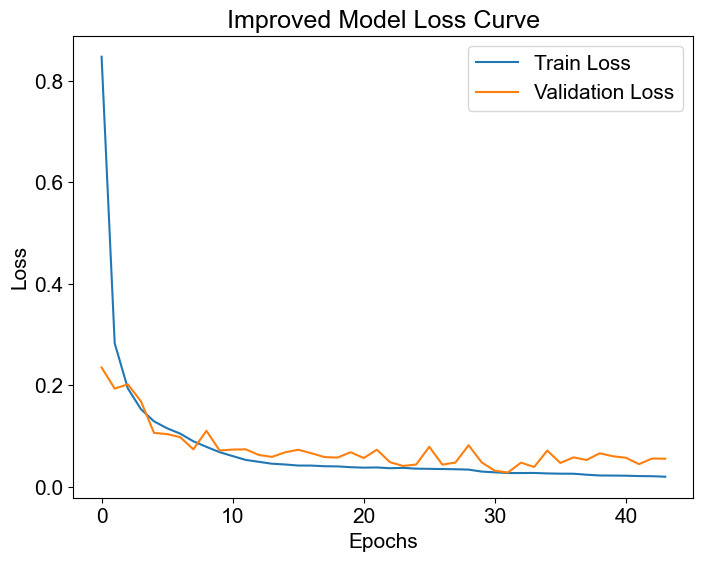

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os

# Define config paths

output_path = os.path.join(config['output'], "Brazil")
os.makedirs(output_path, exist_ok=True)

# Define RMSE Function
def root_mean_squared_error(true_values, predicted_values):
    return mean_squared_error(true_values, predicted_values, squared=False)

# Utility functions
def calculate_nrmse(true_values, predicted_values):
    return root_mean_squared_error(true_values, predicted_values) / (true_values.max() - true_values.min())

def calculate_mae(true_values, predicted_values):
    return mean_absolute_error(true_values, predicted_values)

def calculate_mse(true_values, predicted_values):
    return mean_squared_error(true_values, predicted_values)

def calculate_rmse(mse):
    return mse ** 0.5

def calculate_mape(true_values, predicted_values):
    return mean_absolute_percentage_error(true_values, predicted_values)

def calculate_r2(true_values, predicted_values):
    return r2_score(true_values, predicted_values)

# Ensure validation data is scaled properly
target_scaler = StandardScaler()
y_train_a = target_scaler.fit_transform(y_train_a)
y_val = target_scaler.transform(y_val)  # Removed `y_val_a`, use `y_val` directly

# Check if training is required
TRAINING = False  # Set to False to skip training and load the model if it exists

if TRAINING:
    print("Training the model...")
    history = tcn.train(training=trainingT, validation=validationT, output_path=os.path.join(config['output'], "Brazil"))

else:
    print("Checking for saved models...")
    tcn_models = glob(os.path.join(output_path, "TCN-new-search-*.keras"))
    
    if not tcn_models:
        print('No file found with the pattern. Run TRAINING = True first.')
        exit()
    else:
        tcn.load(tcn_models[-1])
        print(f"Loading model from: {tcn_models[-1]}")

    # Prepare Data
    trainT, valT = dataset_handler.prepare_data_LSTM(x_train[:,:,2:], y_train, x_val[:,:,2:], y_val)
    
    # Make Predictions
    preds_tra = tcn.model.predict(trainT[0])
    preds_val = tcn.model.predict(valT[0])

    # Ensure No Negative Predictions (Use np.clip Instead of Direct Assignment)
    preds_tra = np.clip(preds_tra, 0, None)  # Ensures values stay ≥ 0
    preds_val = np.clip(preds_val, 0, None)

    # Inverse Transform Predictions
    preds_val_original = target_scaler.inverse_transform(preds_val)
    y_val_original = target_scaler.inverse_transform(valT[1])
    preds_tra_original = target_scaler.inverse_transform(preds_tra)
    y_train_original = target_scaler.inverse_transform(trainT[1])

    # Results List
    results = []
    
    for department_idx, department_name in DEP_NAMES.items():
        department_rows_val = validation_dataframe[validation_dataframe['dep_id'] == department_idx]
        department_rows_train = training_dataframe[training_dataframe['dep_id'] == department_idx]

        if department_rows_val.empty or department_rows_train.empty:
            continue

        # Matching Indices (Use np.intersect1d Instead of Loops)
        department_indices_val = np.intersect1d(y_val_indices_df['actual_index'], department_rows_val.index)
        department_indices_train = np.intersect1d(y_train_indices_df['actual_index'], department_rows_train.index)

        if department_indices_val.size == 0 or department_indices_train.size == 0:
            continue

        # Extract True and Predicted Values
        true_val = y_val_original[department_indices_val]
        predicted_val = preds_val_original[department_indices_val]
        true_train = y_train_original[department_indices_train]
        predicted_train = preds_tra_original[department_indices_train]

        # Calculate Metrics
        metrics = {
            'Department': department_name,
            'MAE (Val)': calculate_mae(true_val, predicted_val),
            'RMSE (Val)': calculate_rmse(calculate_mse(true_val, predicted_val)),
            'MAPE (Val)': calculate_mape(true_val, predicted_val),
            'R2 (Val)': calculate_r2(true_val, predicted_val),
            'MAE (Train)': calculate_mae(true_train, predicted_train),
            'RMSE (Train)': calculate_rmse(calculate_mse(true_train, predicted_train)),
            'MAPE (Train)': calculate_mape(true_train, predicted_train),
            'R2 (Train)': calculate_r2(true_train, predicted_train),
        }

        results.append(metrics)

    # Save Results to CSV
    results_df = pd.DataFrame(results)
    today = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    output_path = os.path.join(config['metrics'], "Brazil", f'TCN_new_model_search_{today}.csv')
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    results_df.to_csv(output_file, index=False)
    
    print(f"Results saved to {output_file}")


In [67]:
import os
from glob import glob

output_path = os.path.join(config['output'], "Brazil")
saved_models = glob(os.path.join(output_path, "TCN-new-search-*.keras"))
print("Saved Models:", saved_models)


Saved Models: ['./outputs\\Brazil\\TCN-new-search-05-02-2025-20-09-43.keras']


In [73]:
print("y_val_original is defined:", 'y_val_original' in locals())
print("preds_val_original is defined:", 'preds_val_original' in locals())


y_val_original is defined: False
preds_val_original is defined: False


In [74]:
print("target_scaler is defined:", 'target_scaler' in locals())


target_scaler is defined: True


In [76]:
print("valT[1] exists:", 'valT' in locals() and len(valT) > 1)
print("valT[1] shape:", valT[1].shape if 'valT' in locals() and len(valT) > 1 else "Not Defined")


valT[1] exists: False
valT[1] shape: Not Defined


In [78]:
trainingT, validationT = dataset_handler.prepare_data_LSTM(x_train_a[:,:,2:], y_train_a, x_val[:,:,2:], y_val_a)

print("validationT exists:", 'validationT' in locals())
print("validationT length:", len(validationT) if 'validationT' in locals() else "Not Defined")
print("validationT[1] exists:", len(validationT) > 1 if 'validationT' in locals() else "Not Defined")
print("validationT[1] shape:", validationT[1].shape if len(validationT) > 1 else "Not Defined")


[autoreload of datasetHandler failed: Traceback (most recent call last):
  File "C:\Users\amanp\.conda\envs\minor\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\amanp\.conda\envs\minor\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\amanp\.conda\envs\minor\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "C:\Users\amanp\Desktop\MINOR\projj\code\datasetHandler.py", line 132
    ...
    ^^^
IndentationErro

NameError: name 'y_val_a' is not defined

In [72]:
mse_dengrate_all = mean_squared_error(y_val_original[:, 0], preds_val_original[:, 0])
rmse_dengrate_all = np.sqrt(mse_dengrate_all)
mae_dengrate_all = mean_absolute_error(y_val_original[:, 0], preds_val_original[:, 0])
mape_dengrate_all = mean_absolute_percentage_error(y_val_original[:, 0], preds_val_original[:, 0])
r2_dengrate_all = r2_score(y_val_original[:, 0], preds_val_original[:, 0])

# For the second output (DengRate_019):
mse_dengrate_019 = mean_squared_error(y_val_original[:, 1], preds_val_original[:, 1])
rmse_dengrate_019 = np.sqrt(mse_dengrate_019)
mae_dengrate_019 = mean_absolute_error(y_val_original[:, 1], preds_val_original[:, 1])
mape_dengrate_019 = mean_absolute_percentage_error(y_val_original[:, 1], preds_val_original[:, 1])
r2_dengrate_019 = r2_score(y_val_original[:, 1], preds_val_original[:, 1])

# Print the results
print(f"MSE DengRate_all: {mse_dengrate_all}, RMSE DengRate_all: {rmse_dengrate_all}, MAE DengRate_all: {mae_dengrate_all}, MAPE DengRate_all: {mape_dengrate_all}, R2 DengRate_all: {r2_dengrate_all}")
print(f"MSE DengRate_019: {mse_dengrate_019}, RMSE DengRate_019: {rmse_dengrate_019}, MAE DengRate_019: {mae_dengrate_019}, MAPE DengRate_019: {mape_dengrate_019}, R2 DengRate_019: {r2_dengrate_019}")

NameError: name 'y_val_original' is not defined

In [66]:
y_pred = tcn.model.predict(x_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Performance: R² = {r2:.4f}, MAE = {mae:.4f}")


NameError: name 'x_test' is not defined

In [ ]:
from tensorflow.keras.models import load_model
import glob

# Find the most recent saved model
tcn_models = glob.glob(os.path.join(output_path, "TCN-new-search-*.keras"))
if tcn_models:
    latest_model_path = max(tcn_models, key=os.path.getctime)  # Get the most recent model
    tcn.load(latest_model_path)
    print(f"Loaded best model from {latest_model_path}")

In [ ]:
# Make predictions
preds_val = tcn.model.predict(validationT[0])
preds_val[preds_val < 0] = 0  # Ensure non-negative values

# Convert back to original scale
preds_val_original = scaler.inverse_transform(preds_val)
y_val_original = scaler.inverse_transform(validationT[1])

# Calculate metrics
mse = mean_squared_error(y_val_original, preds_val_original)
rmse = calculate_rmse(mse)
mae = calculate_mae(y_val_original, preds_val_original)
mape = calculate_mape(y_val_original, preds_val_original)
r2 = calculate_r2(y_val_original, preds_val_original)

print(f"Evaluation Metrics on Validation Set:")
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}, R²: {r2:.4f}")


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_val_original, label="Actual Dengue Rate", color='blue', alpha=0.7)
plt.plot(preds_val_original, label="Predicted Dengue Rate", color='red', linestyle='dashed', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Dengue Rate")
plt.title("Actual vs Predicted Dengue Rates")
plt.legend()
plt.show()


In [ ]:
residuals = y_val_original - preds_val_original
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


In [ ]:
true_labels = discretize_to_binary(y_val_original)  # Convert to binary
pred_labels = discretize_to_binary(preds_val_original)

plot_confusion_matrix(true_labels, pred_labels, department_name="Brazil", metric_type="Validation")


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
